In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_po = pd.read_csv("Purchase_orders_2024.csv")
df_vp = pd.read_csv("Vendor_Payments_2024.csv")

/tmp/ipykernel_178631/2446467414.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_po = pd.read_csv("Purchase_orders_2024.csv")
/tmp/ipykernel_178631/2446467414.py:2: DtypeWarning: Columns (20,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vp = pd.read_csv("Vendor_Payments_2024.csv")


In [3]:
def to_float(x):
    if pd.isna(x): return np.nan
    try:
        return float(str(x).replace(',', ''))
    except:
        return np.nan

In [4]:
df_po['PO6'] = (pd.to_numeric(df_po['Purchase Order'], errors='coerce')
                  .astype('Int64')
                  .astype(str)
                  .str.replace('<NA>','', regex=False))

# Payments often have 8-digit PO: first 6 = base, last 2 = line/release
vp_po_str = (pd.to_numeric(df_vp['Purchase Order'], errors='coerce')
               .astype('Int64').astype(str).str.replace('<NA>','', regex=False))

# robust: if length >= 6 take first 6; else keep as is
df_vp['PO6'] = vp_po_str.apply(lambda s: s[:6] if isinstance(s, str) and len(s) >= 6 else s)
df_vp['PO_line'] = vp_po_str.apply(lambda s: s[-2:] if isinstance(s, str) and len(s) >= 8 else np.nan)

# 2) Clean amounts
for c in ['Vouchers Paid','Vouchers Pending','Encumbrance Balance']:
    if c in df_vp.columns: df_vp[c] = df_vp[c].apply(to_float)
if 'Encumbered Amount' in df_po.columns:
    df_po['Encumbered Amount'] = df_po['Encumbered Amount'].apply(to_float)

# 3) Quick sanity on the pattern
print("payments PO length value counts:\n", vp_po_str.str.len().value_counts().head())
print("example mapping:\n", df_vp[['Purchase Order','PO6','PO_line']].head())


payments PO length value counts:
 Purchase Order
8     161136
0      93200
7        269
12         8
5          1
Name: count, dtype: int64
example mapping:
   Purchase Order     PO6 PO_line
0       74371601  743716      01
1       74372101  743721      01
2       74372701  743727      01
3       74373101  743731      01
4       74373701  743737      01


In [17]:
date_candidates = ['data_as_of', 'Purchase Order Date', 'data_loaded_at']
_pay_dt = next((c for c in date_candidates if c in df_vp.columns), None)
assert _pay_dt is not None, "No suitable date column found in df_vp."

# 2) normalize PO6 on payments side and parse dates
vp_po6 = (pd.to_numeric(df_vp['Purchase Order'], errors='coerce')
            .astype('Int64').astype(str).str.replace('<NA>','', regex=False).str[:6])
vp_dates = (df_vp.assign(PO6_key=vp_po6,
                         _pay_dt=pd.to_datetime(df_vp[_pay_dt], errors='coerce', utc=True).dt.tz_localize(None))
                 .groupby('PO6_key')['_pay_dt']
                 .agg(first_voucher_date='min', last_voucher_date='max')
                 .reset_index())

In [15]:
agg_vp = (df_vp.groupby('PO6', dropna=False)
            .agg(vouchers_paid_sum=('Vouchers Paid','sum'),
                 vouchers_pending_sum=('Vouchers Pending','sum'),
                 encum_balance_sum=('Encumbrance Balance','sum'),
                 vouchers_count=('Purchase Order','size'))
            .reset_index()
            .rename(columns={'PO6':'PO6_key'}))

df_po['PO6_key'] = df_po['PO6']

# 5) Join
df_join = df_po.merge(agg_vp, on='PO6_key', how='left')

# 6) Match diagnostics
matched = df_join['vouchers_count'].notna().sum()
total = len(df_po)
print(f"Matched POs: {matched}/{total} ({matched/total:.1%})")

Matched POs: 420469/491168 (85.6%)


In [16]:
if matched / max(total,1) < 0.2 and 'Contract Number' in df_po.columns and 'Contract Number' in df_vp.columns:
    df_vp_cn = (df_vp.groupby('Contract Number', dropna=False)
                  .agg(vouchers_paid_sum_cn=('Vouchers Paid','sum'),
                       vouchers_pending_sum_cn=('Vouchers Pending','sum'),
                       vouchers_count_cn=('Purchase Order','size'))
                  .reset_index())
    df_join = df_join.merge(df_vp_cn, on='Contract Number', how='left')

# 8) Finish cols
for c in ['vouchers_paid_sum','vouchers_pending_sum','encum_balance_sum','vouchers_count']:
    if c in df_join.columns: df_join[c] = df_join[c].fillna(0)

if 'Encumbered Amount' in df_join.columns:
    df_join['paid_vs_encum_diff'] = df_join['Encumbered Amount'] - df_join.get('vouchers_paid_sum', 0)
    df_join['paid_share_of_encum'] = np.where(df_join['Encumbered Amount']>0,
                                              df_join.get('vouchers_paid_sum',0)/df_join['Encumbered Amount'],
                                              np.nan)

print(df_join[['Purchase Order','PO6_key','vouchers_paid_sum','vouchers_count','paid_share_of_encum']].head())


   Purchase Order PO6_key  vouchers_paid_sum  vouchers_count  \
0          742148  742148            9998.93             1.0   
1          742151  742151            1368.49             6.0   
2          742151  742151            1368.49             6.0   
3          742151  742151            1368.49             6.0   
4          742151  742151            1368.49             6.0   

   paid_share_of_encum  
0             2.150798  
1            35.179692  
2           267.806262  
3           135.494059  
4           244.373214  


In [21]:
df_join = df_join.merge(vp_dates, on='PO6_key', how='left')

# 4) compute lags in days (PO date → first/last voucher)
df_join['Purchase Order Date'] = pd.to_datetime(df_join['Purchase Order Date'], errors='coerce', utc=True).dt.tz_localize(None)
df_join['lag_first_days'] = (df_join['first_voucher_date'] - df_join['Purchase Order Date']) / np.timedelta64(1, 'D')
df_join['lag_last_days']  = (df_join['last_voucher_date']  - df_join['Purchase Order Date']) / np.timedelta64(1, 'D')
def coalesce(df, a, b, out):
    if a in df.columns or b in df.columns:
        df[out] = df.get(a) if a in df.columns else pd.NaT
        if b in df.columns:
            df[out] = df[out].fillna(df[b])
    return df

coalesce(df_join, 'first_voucher_date_x', 'first_voucher_date_y', 'first_voucher_date')
coalesce(df_join, 'last_voucher_date_x',  'last_voucher_date_y',  'last_voucher_date')

# 2) Drop the suffixed columns to avoid confusion
df_join = df_join.drop(columns=[c for c in ['first_voucher_date_x','first_voucher_date_y',
                                            'last_voucher_date_x','last_voucher_date_y'] if c in df_join.columns])

# 3) Ensure all date columns are tz-naive datetimes
for c in ['Purchase Order Date','first_voucher_date','last_voucher_date']:
    df_join[c] = pd.to_datetime(df_join[c], errors='coerce', utc=True).dt.tz_localize(None)

# 4) Recompute lags (in days, floats)
df_join['lag_first_days'] = (df_join['first_voucher_date'] - df_join['Purchase Order Date']) / np.timedelta64(1, 'D')
df_join['lag_last_days']  = (df_join['last_voucher_date']  - df_join['Purchase Order Date']) / np.timedelta64(1, 'D')

print(df_join[['Purchase Order','first_voucher_date','last_voucher_date','lag_first_days','lag_last_days']].head())

   Purchase Order  first_voucher_date   last_voucher_date  lag_first_days  \
0          742148 2023-11-30 20:06:26 2023-11-30 20:06:26       79.837801   
1          742151 2023-08-31 20:16:01 2023-08-31 20:16:01       49.844456   
2          742151 2023-08-31 20:16:01 2023-08-31 20:16:01       49.844456   
3          742151 2023-08-31 20:16:01 2023-08-31 20:16:01       49.844456   
4          742151 2023-08-31 20:16:01 2023-08-31 20:16:01       49.844456   

   lag_last_days  
0      79.837801  
1      49.844456  
2      49.844456  
3      49.844456  
4      49.844456  


In [20]:
df_join.columns

Index(['Fiscal Year', 'Purchase Order Date', 'Purchase Order',
       'Purchase Order Line', 'Contract Number', 'Contract Title',
       'Purchasing Department', 'Purchasing Department Title',
       'Post Date - Original', 'Post Date - Current', 'Commodity Code',
       'Commodity Title', 'Supplier & Other Non-Supplier Payees',
       'Supplier Street', 'Supplier City', 'Supplier State',
       'Supplier ZIP Code', 'Supplier Contact', 'Supplier Email',
       'Supplier Phone', 'Encumbered Quantity', 'Encumbered Amount',
       'data_as_of', 'data_loaded_at', 'PO6', 'PO6_key', 'vouchers_paid_sum',
       'vouchers_pending_sum', 'encum_balance_sum', 'vouchers_count',
       'paid_vs_encum_diff', 'paid_share_of_encum', 'first_voucher_date_x',
       'last_voucher_date_x', 'lag_first_days', 'lag_last_days',
       'first_voucher_date_y', 'last_voucher_date_y'],
      dtype='object')

In [7]:
print("\n=== Coverage diagnostics ===")
po_with_pay = (df_join['vouchers_count'] > 0).sum()
po_total = len(df_join)
print(f"POs with at least one voucher: {po_with_pay}/{po_total} ({po_with_pay/po_total:.1%})")

print("\nSample POs with no vouchers (head 10):")
print(df_join.loc[df_join['vouchers_count'].eq(0), ['Purchase Order','Supplier & Other Non-Supplier Payees','Encumbered Amount']].head(10))



=== Coverage diagnostics ===
POs with at least one voucher: 420469/491168 (85.6%)

Sample POs with no vouchers (head 10):
     Purchase Order     Supplier & Other Non-Supplier Payees  \
63           742256                       PAPE MACHINERY INC   
75           742296                      OLYMPUS AMERICA INC   
100          742402  REGENTS OF THE UNIVERSITY OF CALIFORNIA   
337          742807                    WORDJET TRANSCRIPTION   
345          742824                STRYKER SALES CORPORATION   
370          742850                    WORDJET TRANSCRIPTION   
408          742948                             PATRICK & CO   
413          742966              AMERICAN PUBLIC POWER ASSOC   
439          743033           BRISBANE HARDWARE & SUPPLY INC   
453          743083                     BI-RITE CATERING LLC   

     Encumbered Amount  
63             1000.00  
75             3560.56  
100           43422.00  
337            1000.00  
345             188.57  
370            5000.00

In [8]:
bins = [-0.01, 0.01, 0.25, 0.5, 0.75, 0.99, 1.01, 2.0, np.inf]
labels = ['0%','0–25%','25–50%','50–75%','75–99%','~100%','100–200%','>200%']
df_join['util_bucket'] = pd.cut(df_join['paid_share_of_encum'], bins=bins, labels=labels)

util_counts = df_join['util_bucket'].value_counts(dropna=False).reindex(labels, fill_value=0)
print("\n=== Utilization buckets (count) ===")
print(util_counts)


=== Utilization buckets (count) ===
util_bucket
0%           70948
0–25%         1775
25–50%        1969
50–75%        2185
75–99%        5932
~100%        23920
100–200%     28372
>200%       354725
Name: count, dtype: int64


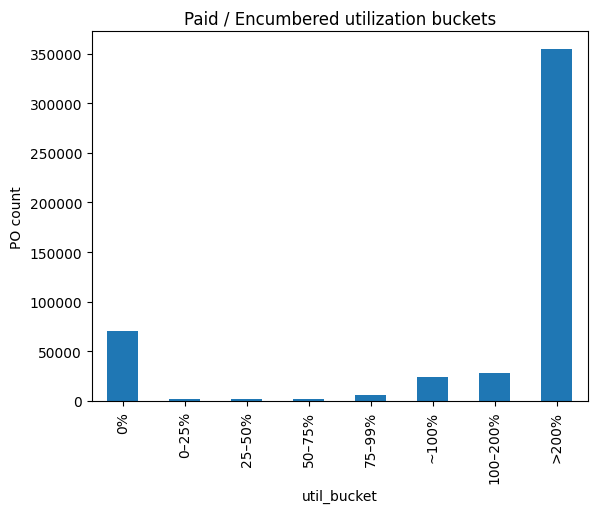

In [9]:
plt.figure()
util_counts.plot(kind='bar')
plt.title("Paid / Encumbered utilization buckets")
plt.ylabel("PO count")
plt.show()

In [10]:
df_join['unpaid_gap'] = df_join['Encumbered Amount'] - df_join['vouchers_paid_sum']
top_unpaid = df_join.sort_values('unpaid_gap', ascending=False).head(20)
print("\nTop-20 largest remaining gaps:")
print(top_unpaid[['Purchase Order','Supplier & Other Non-Supplier Payees','Encumbered Amount','vouchers_paid_sum','unpaid_gap','vouchers_count']])

overspends = df_join.loc[df_join['paid_share_of_encum'] > 1.01]
print(f"\nOverspend candidates (>101% of encumbered): {len(overspends)}")
print(overspends.sort_values('paid_share_of_encum', ascending=False).head(20)
      [['Purchase Order','Supplier & Other Non-Supplier Payees','Encumbered Amount','vouchers_paid_sum','paid_share_of_encum']])



Top-20 largest remaining gaps:
        Purchase Order Supplier & Other Non-Supplier Payees  \
70756           632451                            A P X INC   
70414           530050             GOLDEN GATE CONSTRUCTORS   
70264           387865        HENSEL PHELPS CONSTRUCTION CO   
70187           186047             New Flyer of America Inc   
336514          534385        HENSEL PHELPS CONSTRUCTION CO   
413925          828709               Transbay 2 Senior L.P.   
350973          441717      MCCARTHY BUILDING COMPANIES INC   
346855          646807             TUTOR PERINI CORPORATION   
351713          646807             TUTOR PERINI CORPORATION   
351606          640561            PACIFIC GAS & ELECTRIC CO   
351846          660054  CHILDREN'S COUNCIL OF SAN FRANCISCO   
341820          636770                       HOTEL WHITCOMB   
336523          536483      NEW SOUTH PARKING-CALIFORNIA GP   
351087          534385        HENSEL PHELPS CONSTRUCTION CO   
70312           444209 


Top-20 fragmented POs (many small vouchers):
        Purchase Order Supplier & Other Non-Supplier Payees  vouchers_count  \
80703           751534               ROCHE DIAGNOSTICS CORP            38.0   
276631          751534               ROCHE DIAGNOSTICS CORP            38.0   
127453          819540               ROCHE DIAGNOSTICS CORP            38.0   
408119          819540               ROCHE DIAGNOSTICS CORP            38.0   
66426           671046                      ICF-PANORAMA JV            19.0   
66427           671046                      ICF-PANORAMA JV            19.0   
66428           671046                      ICF-PANORAMA JV            19.0   
66429           671046                      ICF-PANORAMA JV            19.0   
66430           671046                      ICF-PANORAMA JV            19.0   
66431           671046                      ICF-PANORAMA JV            19.0   
66432           671046                      ICF-PANORAMA JV            19.0   
71284 

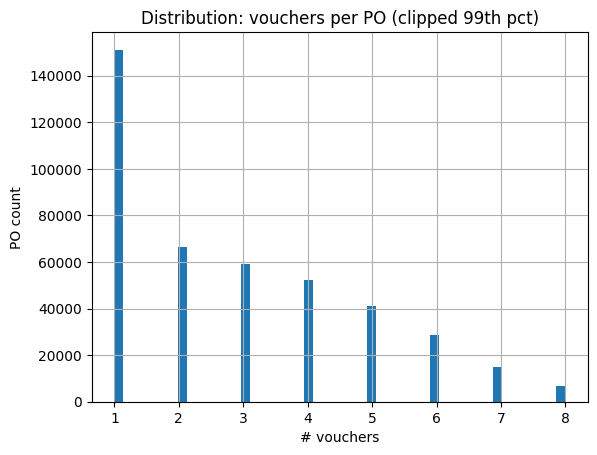

In [11]:
# ========= 4) Fragmentation: many small vouchers per PO =========
vp_sizes = (df_vp.assign(PO6 = pd.to_numeric(df_vp['Purchase Order'], errors='coerce').astype('Int64').astype(str).str.replace('<NA>','', regex=False).str[:6])
                 .groupby('PO6')
                 .agg(voucher_mean=('Vouchers Paid','mean'),
                      voucher_median=('Vouchers Paid','median'),
                      voucher_min=('Vouchers Paid','min'),
                      voucher_max=('Vouchers Paid','max'))
                 .reset_index()
                 .rename(columns={'PO6':'PO6_key'}))

df_join = df_join.merge(vp_sizes, on='PO6_key', how='left')

frag = (df_join[(df_join['vouchers_count']>=5) & (df_join['vouchers_paid_sum']>0)]
        .sort_values(['vouchers_count','voucher_mean'], ascending=[False, True])
        .head(20))
print("\nTop-20 fragmented POs (many small vouchers):")
print(frag[['Purchase Order','Supplier & Other Non-Supplier Payees','vouchers_count','voucher_mean','vouchers_paid_sum','Encumbered Amount','paid_share_of_encum']])

plt.figure()
(df_join.loc[df_join['vouchers_count']>0,'vouchers_count']
        .clip(upper=df_join['vouchers_count'].quantile(0.99))).hist(bins=50)
plt.title("Distribution: vouchers per PO (clipped 99th pct)")
plt.xlabel("# vouchers")
plt.ylabel("PO count")
plt.show()


In [38]:
import numpy as np
import pandas as pd

# --- 1) Pick/prepare the payment timestamp in df_vp ---
_pay_dt = None
for cand in ['data_as_of', 'Purchase Order Date', 'data_loaded_at']:
    if cand in df_vp.columns:
        _pay_dt = cand
        break

if _pay_dt is None:
    raise ValueError("No suitable payment date column found in df_vp")

df_vp[_pay_dt] = pd.to_datetime(df_vp[_pay_dt], errors='coerce')

# --- 2) If df_join has no voucher dates yet, derive vp_dates and merge once ---
has_any_dates = any(c.startswith('first_voucher_date') for c in df_join.columns) \
                or any(c.startswith('last_voucher_date') for c in df_join.columns)

if not has_any_dates:
    vp_dates = (
        df_vp
        .assign(
            PO6=pd.to_numeric(df_vp['Purchase Order'], errors='coerce')
                   .astype('Int64').astype(str)
                   .str.replace('<NA>', '', regex=False)
                   .str[:6]
        )
        .groupby('PO6')[_pay_dt]
        .agg(first_voucher_date='min', last_voucher_date='max')
        .reset_index()
        .rename(columns={'PO6': 'PO6_key'})
    )
    # Merge in, avoid creating new _x/_y by choosing suffixes
    df_join = df_join.merge(vp_dates, on='PO6_key', how='left', suffixes=('', '_vp'))

# --- 3) Coalesce *_x/*_y (or *_vp) to clean columns ---
def _coalesce_cols(df, base):
    # All columns that start with base (e.g., 'first_voucher_date')
    cols = [c for c in df.columns if c == base or c.startswith(base + '_')]
    if not cols:
        return pd.NaT
    # Ensure datetime, then bfill across columns row-wise
    tmp = df[cols].apply(pd.to_datetime, errors='coerce')
    return tmp.bfill(axis=1).iloc[:, 0]

df_join['first_voucher_date'] = _coalesce_cols(df_join, 'first_voucher_date')
df_join['last_voucher_date']  = _coalesce_cols(df_join,  'last_voucher_date')

# --- 4) Clean up: drop the messy duplicates if you want ---
dups = [c for c in df_join.columns if c.startswith('first_voucher_date_') or c.startswith('last_voucher_date_')]
if dups:
    df_join.drop(columns=dups, inplace=True)

# --- 5) Ensure PO date is timezone-naive datetime ---
df_join['Purchase Order Date'] = pd.to_datetime(df_join['Purchase Order Date'], errors='coerce', utc=True).dt.tz_localize(None)
df_join['first_voucher_date']  = pd.to_datetime(df_join['first_voucher_date'],  errors='coerce', utc=True).dt.tz_localize(None)
df_join['last_voucher_date']   = pd.to_datetime(df_join['last_voucher_date'],   errors='coerce', utc=True).dt.tz_localize(None)

# --- 6) Lags (in days) ---
df_join['lag_first_days'] = (df_join['first_voucher_date'] - df_join['Purchase Order Date']).dt.days
df_join['lag_last_days']  = (df_join['last_voucher_date']  - df_join['Purchase Order Date']).dt.days

# Optional: clip negatives to 0 if you consider early vouchers as data errors
# df_join['lag_first_days'] = df_join['lag_first_days'].clip(lower=0)
# df_join['lag_last_days']  = df_join['lag_last_days'].clip(lower=0)

print(df_join[['Purchase Order','PO6_key','first_voucher_date','last_voucher_date','lag_first_days','lag_last_days']].head())


   Purchase Order PO6_key  first_voucher_date   last_voucher_date  \
0          742148  742148 2023-11-30 20:06:26 2023-11-30 20:06:26   
1          742151  742151 2023-08-31 20:16:01 2023-08-31 20:16:01   
2          742151  742151 2023-08-31 20:16:01 2023-08-31 20:16:01   
3          742151  742151 2023-08-31 20:16:01 2023-08-31 20:16:01   
4          742151  742151 2023-08-31 20:16:01 2023-08-31 20:16:01   

   lag_first_days  lag_last_days  
0            79.0           79.0  
1            49.0           49.0  
2            49.0           49.0  
3            49.0           49.0  
4            49.0           49.0  


In [40]:
df_join.columns

Index(['Fiscal Year', 'Purchase Order Date', 'Purchase Order',
       'Purchase Order Line', 'Contract Number', 'Contract Title',
       'Purchasing Department', 'Purchasing Department Title',
       'Post Date - Original', 'Post Date - Current', 'Commodity Code',
       'Commodity Title', 'Supplier & Other Non-Supplier Payees',
       'Supplier Street', 'Supplier City', 'Supplier State',
       'Supplier ZIP Code', 'Supplier Contact', 'Supplier Email',
       'Supplier Phone', 'Encumbered Quantity', 'Encumbered Amount',
       'data_as_of', 'data_loaded_at', 'PO6', 'PO6_key', 'vouchers_paid_sum',
       'vouchers_pending_sum', 'encum_balance_sum', 'vouchers_count',
       'first_voucher_date', 'last_voucher_date', 'lag_first_days',
       'lag_last_days'],
      dtype='object')

In [32]:
def qclip(s, q=0.99, lower=None):
    s = pd.to_numeric(s, errors='coerce')
    hi = s.quantile(q) if s.notna().any() else np.nan
    lo = lower if lower is not None else s.quantile(1-q) if s.notna().any() else np.nan
    return s.clip(lower=lo if not np.isnan(lo) else None, upper=hi if not np.isnan(hi) else None)

def monthify(df, col):
    c = pd.to_datetime(df[col], errors='coerce')
    return c.dt.to_period('M')


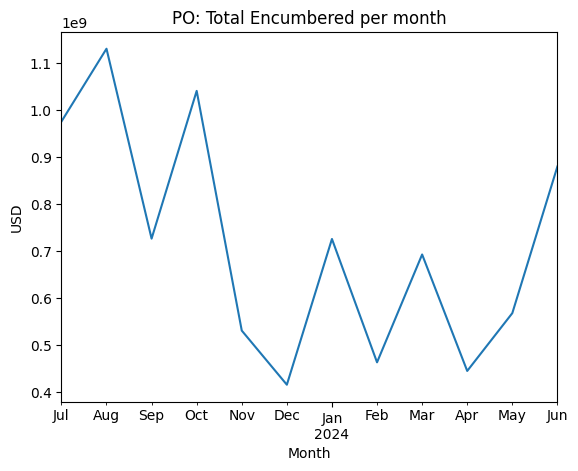

In [33]:
# ---------- 3) Trends (monthly) ----------
# Encumbered per month (by PO date)
if 'Purchase Order Date' in df_po.columns:
    plt.figure()
    (df_po.assign(_m=monthify(df_po, 'Purchase Order Date'))
         .groupby('_m')['Encumbered Amount'].sum()
         .astype(float)
         .plot())
    plt.title("PO: Total Encumbered per month")
    plt.xlabel("Month"); plt.ylabel("USD")
    plt.show()

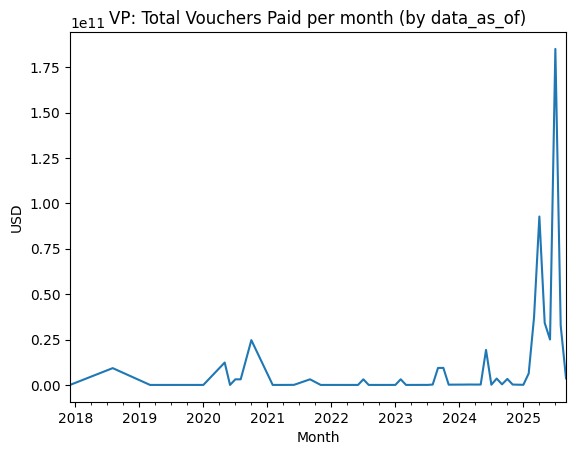

In [34]:
date_candidates = [c for c in ['data_as_of','Purchase Order Date','data_loaded_at'] if c in df_vp.columns]
if date_candidates:
    pay_dt = date_candidates[0]
    plt.figure()
    (df_vp.assign(_m=monthify(df_vp, pay_dt))
         .groupby('_m')['Vouchers Paid'].sum()
         .astype(float)
         .plot())
    plt.title(f"VP: Total Vouchers Paid per month (by {pay_dt})")
    plt.xlabel("Month"); plt.ylabel("USD")
    plt.show()

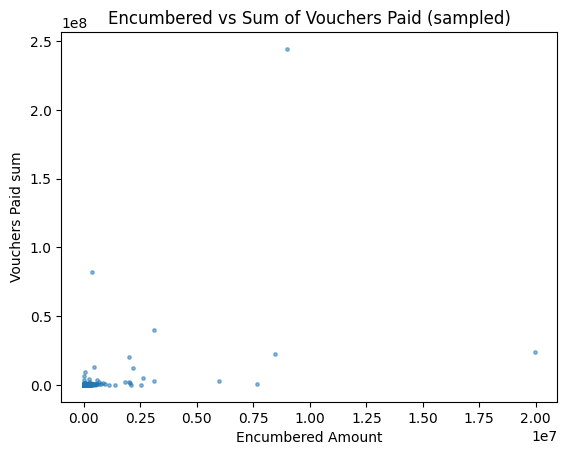

In [35]:
# ---------- 4) Encumbered vs Paid scatter (downsample if large) ----------
sample = df_join.dropna(subset=['Encumbered Amount','vouchers_paid_sum'])
if len(sample) > 6000:
    sample = sample.sample(6000, random_state=42)
plt.figure()
plt.scatter(sample['Encumbered Amount'], sample['vouchers_paid_sum'], s=6, alpha=0.5)
plt.title("Encumbered vs Sum of Vouchers Paid (sampled)")
plt.xlabel("Encumbered Amount"); plt.ylabel("Vouchers Paid sum")
plt.show()


Lag to first voucher (days) — summary:
 count    420469.000000
mean         84.761894
std         105.001906
min       -1475.000000
50%          53.000000
75%          69.000000
90%         146.000000
95%         317.000000
99%         594.000000
max         798.000000
Name: lag_first_days, dtype: float64

Lag to last voucher (days) — summary:
 count    420469.000000
mean         84.773560
std         104.941271
min           0.000000
50%          53.000000
75%          69.000000
90%         146.000000
95%         317.000000
99%         594.000000
max         798.000000
Name: lag_last_days, dtype: float64


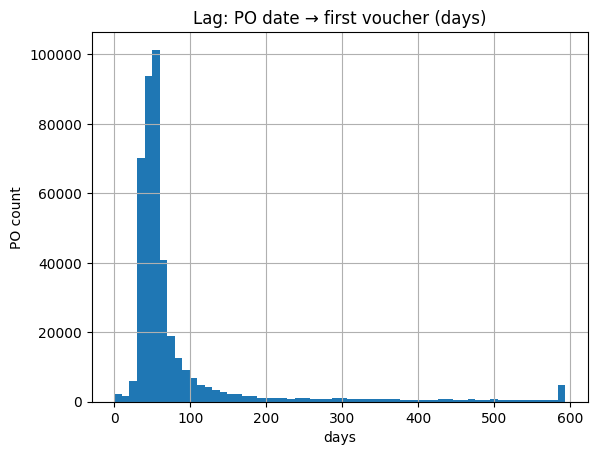

In [42]:
# ---------- 5) Lags ----------
print("\nLag to first voucher (days) — summary:\n",
      df_join['lag_first_days'].describe(percentiles=[.5,.75,.9,.95,.99]))
print("\nLag to last voucher (days) — summary:\n",
      df_join['lag_last_days'].describe(percentiles=[.5,.75,.9,.95,.99]))

plt.figure()
q = np.nanpercentile(df_join['lag_first_days'].dropna(), 99) if df_join['lag_first_days'].notna().any() else 0
df_join['lag_first_days'].dropna().clip(lower=0, upper=q).hist(bins=60)
plt.title("Lag: PO date → first voucher (days)")
plt.xlabel("days"); plt.ylabel("PO count")
plt.show()


In [44]:
for c in ['Encumbered Amount','vouchers_paid_sum','vouchers_pending_sum','encum_balance_sum','vouchers_count']:
    if c in df_join.columns:
        df_join[c] = pd.to_numeric(df_join[c], errors='coerce')

# --- create paid_share_of_encum if missing ---
if 'paid_share_of_encum' not in df_join.columns:
    df_join['paid_share_of_encum'] = np.where(
        df_join['Encumbered Amount'] > 0,
        df_join['vouchers_paid_sum'] / df_join['Encumbered Amount'],
        np.nan
    )

In [48]:
# ---------- Gaps, overspends, fragmentation ----------
df_join['unpaid_gap'] = df_join['Encumbered Amount'] - df_join['vouchers_paid_sum']

top_unpaid = df_join.sort_values('unpaid_gap', ascending=False).head(20)[
    ['Purchase Order','Supplier & Other Non-Supplier Payees','Encumbered Amount',
     'vouchers_paid_sum','unpaid_gap','vouchers_count']
]
print("\nTop-20 remaining gaps (Encumbered - Paid):\n", top_unpaid)


Top-20 remaining gaps (Encumbered - Paid):
         Purchase Order Supplier & Other Non-Supplier Payees  \
70756           632451                            A P X INC   
70414           530050             GOLDEN GATE CONSTRUCTORS   
70264           387865        HENSEL PHELPS CONSTRUCTION CO   
336514          534385        HENSEL PHELPS CONSTRUCTION CO   
413925          828709               Transbay 2 Senior L.P.   
351606          640561            PACIFIC GAS & ELECTRIC CO   
351846          660054  CHILDREN'S COUNCIL OF SAN FRANCISCO   
351087          534385        HENSEL PHELPS CONSTRUCTION CO   
70312           444209              CH2M HILL ENGINEERS INC   
337127          646023                      HEALTHRIGHT 360   
346227          534385        HENSEL PHELPS CONSTRUCTION CO   
337126          645986      NEW SOUTH PARKING-CALIFORNIA GP   
66321           660054  CHILDREN'S COUNCIL OF SAN FRANCISCO   
70294           425208                   C L W BUILDERS INC   
351999    

In [50]:
overspends = df_join.loc[df_join['paid_share_of_encum'] > 1.01].copy()
print(f"\nOverspend candidates (>101%): {len(overspends)}")
print(overspends.sort_values('paid_share_of_encum', ascending=False).head(20)[
    ['Purchase Order','Supplier & Other Non-Supplier Payees','Encumbered Amount',
     'vouchers_paid_sum','paid_share_of_encum']
])


Overspend candidates (>101%): 383097
        Purchase Order   Supplier & Other Non-Supplier Payees  \
487434          671794                 TURNER CONSTRUCTION CO   
347383          707410          HENSEL PHELPS CONSTRUCTION CO   
71129           653815               NEW FLYER OF AMERICA INC   
337224          653815               NEW FLYER OF AMERICA INC   
342080          653815               NEW FLYER OF AMERICA INC   
342081          653815               NEW FLYER OF AMERICA INC   
337223          653815               NEW FLYER OF AMERICA INC   
346938          653815               NEW FLYER OF AMERICA INC   
487271          653815               NEW FLYER OF AMERICA INC   
487272          653815               NEW FLYER OF AMERICA INC   
66271           653815               NEW FLYER OF AMERICA INC   
66270           653815               NEW FLYER OF AMERICA INC   
279041          755161              INSIGHT PUBLIC SECTOR INC   
74769           741603                     ORACLE AM

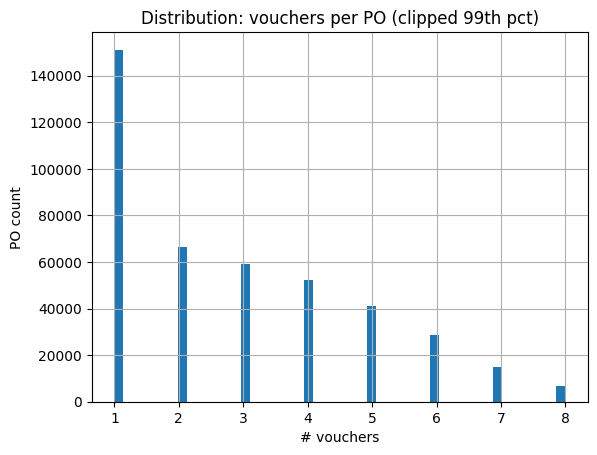

In [51]:
plt.figure()
df_join.loc[df_join['vouchers_count']>0,'vouchers_count'] \
       .clip(upper=df_join['vouchers_count'].quantile(0.99)).hist(bins=50)
plt.title("Distribution: vouchers per PO (clipped 99th pct)")
plt.xlabel("# vouchers"); plt.ylabel("PO count")
plt.show()


Top vendors by total paid:
 Supplier & Other Non-Supplier Payees
REGENTS OF THE UNIVERSITY OF CALIFORNIA     1.329196e+10
HENSEL PHELPS CONSTRUCTION CO               3.031635e+09
CHILDREN'S COUNCIL OF SAN FRANCISCO         2.006865e+09
TURNER CONSTRUCTION CO                      4.862557e+08
GOLDEN GATE CONSTRUCTORS                    4.746237e+08
MEDLINE INDUSTRIES INC                      4.295754e+08
RUBECON GENERAL CONTRACTING INC             3.835015e+08
WU YEE CHILDREN'S SERVICES                  3.763147e+08
LAZ PARKING CALIFORNIA LLC                  2.184441e+08
HUNTERS POINT FAMILY                        2.152033e+08
MOSCONE CENTER JOINT VENTURE                2.145937e+08
SF IN-HOME SPPRTIV SVCS (IHSS) PUBL AUTH    1.931052e+08
DEPARTMENT OF SOCIAL SERVICES               1.735540e+08
REGENTS UNIV OF CA / SFGH PSYCHIATRY DPT    1.651622e+08
HEALTHRIGHT 360                             1.304952e+08
Name: vouchers_paid_sum, dtype: float64


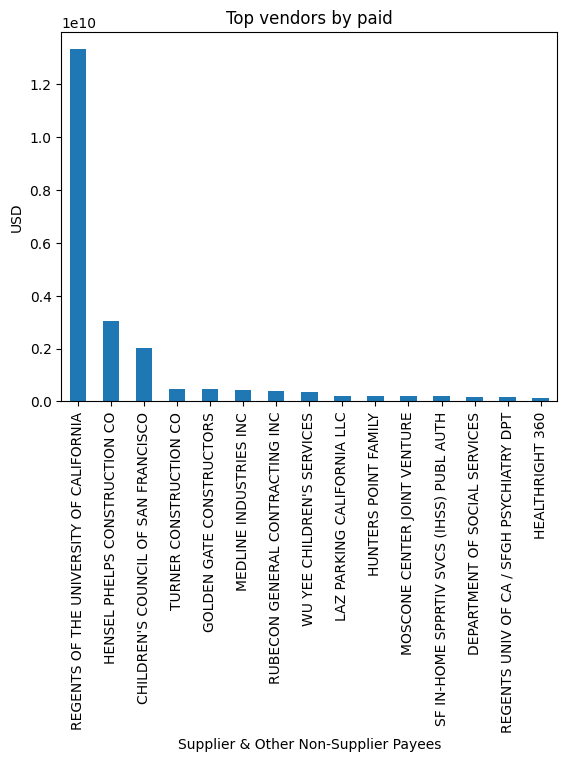


Top departments (encumbered vs paid):
                                    encum_sum      paid_sum
Purchasing Department Title                               
AIR Airport Commission          1.388472e+09  4.732384e+09
PUC Public Utilities Commsn     1.301850e+09  1.657814e+09
DPH Public Health               1.255146e+09  1.567189e+10
MTA Municipal Transprtn Agncy   6.909563e+08  9.503001e+08
MYR Mayor                       6.471297e+08  1.162255e+09
HSA Human Services Agency       6.067497e+08  7.280508e+08
HOM Homelessness Services       5.716366e+08  4.279912e+08
DEC Dept of Early Childhood     3.823909e+08  2.437961e+09
DPW Public Works                3.494666e+08  7.260765e+08
ADM GSA - City Administrator    2.501268e+08  4.255714e+08
CHF Children;Youth & Families   1.919757e+08  3.491620e+08
CII Commty Invest & Infrstrctr  1.851653e+08  5.971757e+07
ECN Economic & Wrkfrce Dvlpmnt  1.500744e+08  2.036772e+08
DT  GSA - Technology            9.188592e+07  1.285729e+08
PRT Port        

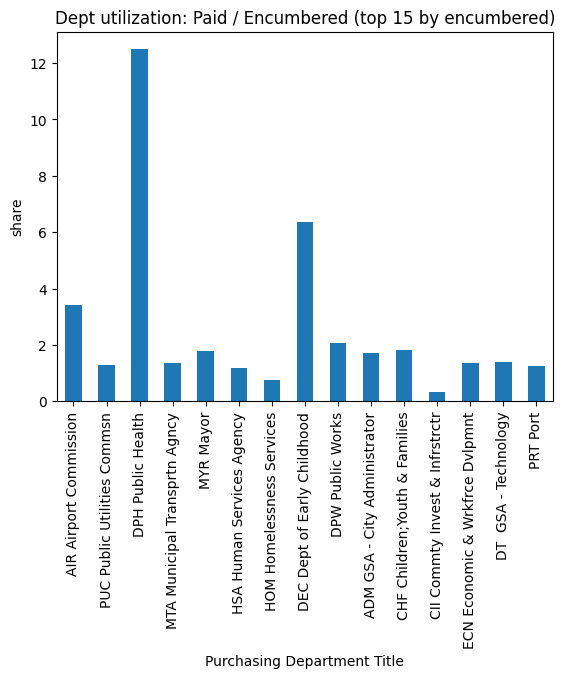

In [52]:
if 'Supplier & Other Non-Supplier Payees' in df_join.columns:
    top_vendors_paid = (df_join.groupby('Supplier & Other Non-Supplier Payees')['vouchers_paid_sum']
                              .sum().sort_values(ascending=False).head(15))
    print("\nTop vendors by total paid:\n", top_vendors_paid)
    plt.figure(); top_vendors_paid.plot(kind='bar')
    plt.title("Top vendors by paid"); plt.ylabel("USD")
    plt.show()

if 'Purchasing Department Title' in df_join.columns:
    dept = (df_join.groupby('Purchasing Department Title')
                 .agg(encum_sum=('Encumbered Amount','sum'),
                      paid_sum=('vouchers_paid_sum','sum'))
                 .sort_values('encum_sum', ascending=False).head(15))
    print("\nTop departments (encumbered vs paid):\n", dept)
    plt.figure(); (dept['paid_sum']/dept['encum_sum']).plot(kind='bar')
    plt.title("Dept utilization: Paid / Encumbered (top 15 by encumbered)")
    plt.ylabel("share")
    plt.show()


Vendors with highest Prop Q share:
 Supplier & Other Non-Supplier Payees
1-800-GOT-JUNK                         1.0
HORIZONS TRAVEL GROUP                  1.0
HONEY BUCKET                           1.0
HOMETOWN MEDICAL SUPPLIES              1.0
HOLZMUELLER CORP                       1.0
HOLLINGER METAL EDGE INC               1.0
HOFFMEYER COMPANY INC                  1.0
HICO AMERICA SALES & TECHNOLOGY INC    1.0
HEIDELBERG ENGINEERING INC             1.0
HEAVY EQUIPMENT PARTS INC              1.0
HANSON & FITCH INC.                    1.0
HAM RADIO OUTLET                       1.0
HALO Branded Solutions Inc.            1.0
H Y FLOOR HARDWOOD FLOORS              1.0
H & H PRINTING INC                     1.0
Name: _propq, dtype: float64


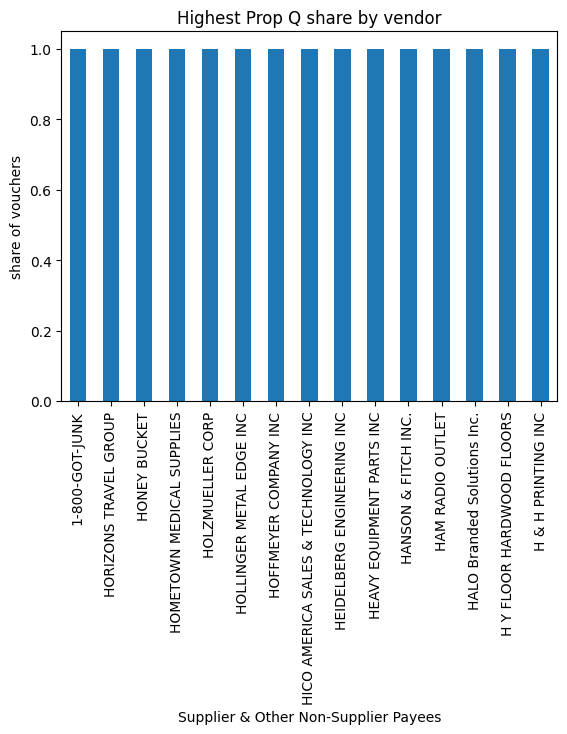

In [53]:
if 'Purchasing Authority Description' in df_vp.columns:
    df_vp['_propq'] = (df_vp['Purchasing Authority Description'].astype(str)
                       .str.upper().eq('PROP Q AUTHORITY NOT BID')).astype(int)
    propq_vendor = (df_vp.groupby('Supplier & Other Non-Supplier Payees')['_propq']
                       .mean().sort_values(ascending=False).head(15))
    print("\nVendors with highest Prop Q share:\n", propq_vendor)
    plt.figure(); propq_vendor.plot(kind='bar')
    plt.title("Highest Prop Q share by vendor"); plt.ylabel("share of vouchers")
    plt.show()

In [54]:
num_cols = ['Encumbered Amount','vouchers_paid_sum','vouchers_pending_sum',
            'encum_balance_sum','vouchers_count','paid_share_of_encum',
            'unpaid_gap','lag_first_days','lag_last_days']
corr = df_join[num_cols].corr(numeric_only=True)
print("\nCorrelation matrix (numeric):\n", corr.round(3))


Correlation matrix (numeric):
                       Encumbered Amount  vouchers_paid_sum  \
Encumbered Amount                 1.000              0.240   
vouchers_paid_sum                 0.240              1.000   
vouchers_pending_sum              0.009              0.002   
encum_balance_sum                 0.049              0.026   
vouchers_count                   -0.013             -0.009   
paid_share_of_encum              -0.000              0.020   
unpaid_gap                       -0.041             -0.980   
lag_first_days                    0.066              0.052   
lag_last_days                     0.066              0.052   

                      vouchers_pending_sum  encum_balance_sum  vouchers_count  \
Encumbered Amount                    0.009              0.049          -0.013   
vouchers_paid_sum                    0.002              0.026          -0.009   
vouchers_pending_sum                 1.000              0.000          -0.002   
encum_balance_sum      

In [56]:
# ---- helpers ----
def zscore_group(df, val_col, by_col):
    def _z(s):
        m, sd = s.mean(), s.std(ddof=0)
        return (s - m)/sd if sd and sd>0 else pd.Series(np.nan, index=s.index)
    return df.groupby(by_col)[val_col].transform(_z)



In [58]:
# 1) Coerce numerics from messy strings like "4,648.94", "0", "nan"
for col in ['Encumbered Quantity', 'Encumbered Amount',
            'vouchers_paid_sum', 'vouchers_pending_sum', 'encum_balance_sum']:
    if col in df_join.columns:
        # strip commas/whitespace; keep minus signs if any
        df_join[col] = (df_join[col]
                        .astype(str)
                        .str.replace(',', '', regex=False)
                        .str.strip())
        df_join[col] = pd.to_numeric(df_join[col], errors='coerce')

# 2) Compute price-per-unit only where quantity > 0
qty = df_join['Encumbered Quantity']
amt = df_join['Encumbered Amount']
mask = qty.gt(0)  # works now because qty is numeric
df_join['ppu_encum'] = np.where(mask, amt / qty, np.nan)

In [60]:
# 3) Z-score within commodity (guard against groups with 0/NaN std)
def _zscore_group(s):
    m = s.mean()
    sd = s.std(ddof=0)
    if not np.isfinite(sd) or sd == 0:
        return pd.Series(np.nan, index=s.index)
    return (s - m) / sd

In [61]:
if 'Commodity Title' in df_join.columns:
    df_join['ppu_z'] = df_join.groupby('Commodity Title')['ppu_encum'].transform(_zscore_group)
else:
    df_join['ppu_z'] = np.nan

print(df_join[['Encumbered Quantity','Encumbered Amount','ppu_encum','ppu_z']].head())

   Encumbered Quantity  Encumbered Amount  ppu_encum     ppu_z
0                  0.0            4648.94        NaN       NaN
1                 10.0              38.90      3.890 -0.066950
2                 10.0               5.11      0.511 -0.179797
3                 10.0              10.10      1.010 -0.160115
4                 10.0               5.60      0.560 -0.094565


In [62]:
need_nums = ['Encumbered Amount','vouchers_paid_sum','vouchers_pending_sum','encum_balance_sum','vouchers_count']
for c in need_nums:
    if c in df_join.columns:
        df_join[c] = pd.to_numeric(df_join[c], errors='coerce')

if 'paid_share_of_encum' not in df_join.columns:
    df_join['paid_share_of_encum'] = np.where(df_join['Encumbered Amount']>0,
                                              df_join['vouchers_paid_sum']/df_join['Encumbered Amount'], np.nan)
df_join['pending_share'] = np.where(df_join['Encumbered Amount']>0,
                                    df_join['vouchers_pending_sum']/df_join['Encumbered Amount'], np.nan)
df_join['unpaid_gap'] = df_join['Encumbered Amount'] - df_join['vouchers_paid_sum']

# ---------- 2) PO-level flags ----------
BUF = 1.05  # 5% buffer
df_join['FLAG_overpaid'] = (df_join['Encumbered Amount']>0) & (df_join['vouchers_paid_sum'] > BUF*df_join['Encumbered Amount'])
df_join['FLAG_paid_without_encum'] = (df_join['Encumbered Amount'].fillna(0)==0) & (df_join['vouchers_paid_sum']>0)
df_join['FLAG_many_small_vouchers'] = (df_join['vouchers_count']>=5) & (df_join['vouchers_paid_sum']>0)

# long-lag flags (robust to missing)
p95_first = np.nanpercentile(df_join['lag_first_days'].dropna(), 95) if df_join['lag_first_days'].notna().any() else np.nan
df_join['FLAG_long_lag'] = df_join['lag_first_days'] > p95_first if np.isfinite(p95_first) else False

# price outlier by commodity (assuming you computed ppu_z)
df_join['FLAG_price_outlier'] = df_join.get('ppu_z', np.nan).abs() > 3

# high pending but low utilization
df_join['FLAG_high_pending_low_util'] = (df_join['pending_share']>0.5) & (df_join['paid_share_of_encum']<0.2)


In [63]:
_dfvp = df_vp.copy()

# pick best date column available
pay_dt = next((c for c in ['data_as_of','Purchase Order Date','data_loaded_at'] if c in _dfvp.columns), None)
if pay_dt is None:
    # create a dummy NaT column to keep code running
    _dfvp['__pay_dt__'] = pd.NaT
    pay_dt = '__pay_dt__'

_dfvp[pay_dt] = pd.to_datetime(_dfvp[pay_dt], errors='coerce')
_dfvp['Vouchers Paid'] = pd.to_numeric(_dfvp['Vouchers Paid'], errors='coerce')

# normalize PO6_key on vouchers
_dfvp['PO6_key'] = (pd.to_numeric(_dfvp['Purchase Order'], errors='coerce')
                      .astype('Int64').astype(str).str.replace('<NA>','', regex=False).str[:6])

# 3a) duplicate amount within vendor in ±14 days (different PO6)
_dfvp['vendor'] = _dfvp['Supplier & Other Non-Supplier Payees'].astype(str)
g = _dfvp[['vendor', pay_dt, 'Vouchers Paid', 'PO6_key']].dropna(subset=['vendor','Vouchers Paid'])
g['amount_key'] = g['Vouchers Paid'].round(2)

dup = g.merge(g, on=['vendor','amount_key'], suffixes=('_a','_b'))
dup['delta_days'] = (dup[f'{pay_dt}_b'] - dup[f'{pay_dt}_a']).dt.days.abs()
dup = dup[(dup['delta_days']<=14) & (dup['PO6_key_a']!=dup['PO6_key_b'])]
dup_po = dup.groupby('PO6_key_a').size().rename('dup_within14_cnt').reset_index().rename(columns={'PO6_key_a':'PO6_key'})

df_join = df_join.merge(dup_po, on='PO6_key', how='left')
df_join['dup_within14_cnt'] = df_join['dup_within14_cnt'].fillna(0).astype(int)
df_join['FLAG_dup_amount_within14d'] = df_join['dup_within14_cnt'] >= 2

# 3b) Prop Q splits (if the authority column exists)
if 'Purchasing Authority Description' in _dfvp.columns:
    _dfvp['_is_propq'] = _dfvp['Purchasing Authority Description'].astype(str).str.upper().eq('PROP Q AUTHORITY NOT BID')
    thresh = _dfvp.loc[_dfvp['_is_propq'], 'Vouchers Paid'].quantile(0.95) if _dfvp['_is_propq'].any() else np.nan
    if np.isfinite(thresh):
        splits = (_dfvp[_dfvp['_is_propq'] & (_dfvp['Vouchers Paid']<=thresh)]
                  .groupby('PO6_key').size().rename('propq_small_cnt').reset_index())
        df_join = df_join.merge(splits, on='PO6_key', how='left')
    else:
        df_join['propq_small_cnt'] = 0
else:
    df_join['propq_small_cnt'] = 0

df_join['propq_small_cnt'] = df_join['propq_small_cnt'].fillna(0).astype(int)
df_join['FLAG_propq_splits'] = df_join['propq_small_cnt'] >= 3


In [64]:
HP = (df_join['FLAG_overpaid'] | df_join['FLAG_paid_without_encum'] | df_join['FLAG_dup_amount_within14d'])

# Softer positives
SOFT = (df_join['FLAG_propq_splits'] | df_join['FLAG_price_outlier'])

df_join['weak_label'] = np.where(HP, 1,
                          np.where(SOFT, 1, np.nan))

# Conservative negatives (silver)
NEG = (
    df_join['weak_label'].isna() &
    df_join['paid_share_of_encum'].between(0.8, 1.0, inclusive='both') &
    df_join['vouchers_count'].between(1, 3) &
    (~df_join[['FLAG_overpaid','FLAG_paid_without_encum','FLAG_dup_amount_within14d',
               'FLAG_propq_splits','FLAG_price_outlier','FLAG_high_pending_low_util','FLAG_long_lag',
               'FLAG_many_small_vouchers']].any(axis=1))
)
df_join.loc[NEG, 'weak_label'] = 0

# Simple rule score (0..1)
rule_score = (
    1.0*df_join['FLAG_overpaid'].astype(int) +
    1.0*df_join['FLAG_paid_without_encum'].astype(int) +
    0.8*df_join['FLAG_dup_amount_within14d'].astype(int) +
    0.5*df_join['FLAG_propq_splits'].astype(int) +
    0.4*df_join['FLAG_price_outlier'].astype(int) +
    0.3*df_join['FLAG_high_pending_low_util'].astype(int) +
    0.2*df_join['FLAG_long_lag'].astype(int) +
    0.2*df_join['FLAG_many_small_vouchers'].astype(int)
)
# normalize
if rule_score.max() > rule_score.min():
    rule_score = (rule_score - rule_score.min()) / (rule_score.max() - rule_score.min())
else:
    rule_score = rule_score * 0

df_join['anomaly_score'] = rule_score

# human-readable reasons
flag_cols = ['FLAG_overpaid','FLAG_paid_without_encum','FLAG_dup_amount_within14d','FLAG_propq_splits',
             'FLAG_price_outlier','FLAG_high_pending_low_util','FLAG_long_lag','FLAG_many_small_vouchers']
df_join['explanations'] = df_join[flag_cols].apply(lambda r: [c for c, v in r.items() if v], axis=1)

# ---------- 5) Quick outputs ----------
print("Weak label counts:\n", df_join['weak_label'].value_counts(dropna=False))
print("\nTop-25 anomalies (rule-based):")
cols_show = ['Purchase Order','Supplier & Other Non-Supplier Payees','Encumbered Amount',
             'vouchers_paid_sum','paid_share_of_encum','unpaid_gap',
             'vouchers_count','dup_within14_cnt','propq_small_cnt',
             'lag_first_days','lag_last_days','anomaly_score','explanations']
print(df_join.sort_values('anomaly_score', ascending=False)[cols_show].head(25))


Weak label counts:
 weak_label
1.0    388179
NaN     82935
0.0     20054
Name: count, dtype: int64

Top-25 anomalies (rule-based):
        Purchase Order Supplier & Other Non-Supplier Payees  \
159974          772612        BLAISDELL'S BUSINESS PRODUCTS   
113217          798486       GENERAL PLUMBING SUPPLY CO INC   
290590          772607        BLAISDELL'S BUSINESS PRODUCTS   
113218          798486       GENERAL PLUMBING SUPPLY CO INC   
308461          797434       GENERAL PLUMBING SUPPLY CO INC   
182028          803645        BLAISDELL'S BUSINESS PRODUCTS   
182029          803645        BLAISDELL'S BUSINESS PRODUCTS   
243151          797434       GENERAL PLUMBING SUPPLY CO INC   
243150          797434       GENERAL PLUMBING SUPPLY CO INC   
243149          797434       GENERAL PLUMBING SUPPLY CO INC   
243148          797434       GENERAL PLUMBING SUPPLY CO INC   
243147          797434       GENERAL PLUMBING SUPPLY CO INC   
182030          803645        BLAISDELL'S BUSINESS

In [65]:
flag_cols = [
    'FLAG_overpaid','FLAG_paid_without_encum','FLAG_dup_amount_within14d',
    'FLAG_propq_splits','FLAG_price_outlier','FLAG_high_pending_low_util',
    'FLAG_long_lag','FLAG_many_small_vouchers'
]
for c in flag_cols:
    if c not in df_join.columns:
        df_join[c] = False  # ensure presence

# numeric safety
for c in ['Encumbered Amount','vouchers_paid_sum','vouchers_pending_sum']:
    if c in df_join.columns:
        df_join[c] = pd.to_numeric(df_join[c], errors='coerce')

# ---------------------------
# 1) Overall counts & shares
# ---------------------------
total = len(df_join)
anom = int((df_join['weak_label'] == 1).sum())
clean = int((df_join['weak_label'] == 0).sum())
unlab = int(df_join['weak_label'].isna().sum())

overall = pd.DataFrame({
    'count':   [anom, clean, unlab, total],
    'percent': [anom/total, clean/total, unlab/total, 1.0]
}, index=['anomalies(=1)','clean(=0)','unlabeled','TOTAL'])
print("=== Overall anomaly labeling ===")
print(overall.applymap(lambda x: f"{x:.2%}" if isinstance(x,float) else x))

# Coverage by dollars (how much money is in flagged/anomalous POs)
paid_total = float(df_join['vouchers_paid_sum'].sum())
paid_flagged = float(df_join.loc[df_join['weak_label']==1, 'vouchers_paid_sum'].sum())
enc_total = float(df_join['Encumbered Amount'].sum())
enc_flagged = float(df_join.loc[df_join['weak_label']==1, 'Encumbered Amount'].sum())

money = pd.DataFrame({
    'USD_sum':   [paid_flagged, paid_total, enc_flagged, enc_total],
    'share_%':  [paid_flagged/paid_total if paid_total else np.nan,
                 1.0,
                 enc_flagged/enc_total if enc_total else np.nan,
                 1.0]
}, index=['Paid in anomalies','Paid total','Encumbered in anomalies','Encumbered total'])
print("\n=== Money coverage (anomalies’ share) ===")
print(money.assign(share_pct=(money['share_%']*100).round(2)).drop(columns='share_%'))



=== Overall anomaly labeling ===
                count  percent
anomalies(=1)  388179   79.03%
clean(=0)       20054    4.08%
unlabeled       82935   16.89%
TOTAL          491168  100.00%

=== Money coverage (anomalies’ share) ===
                              USD_sum  share_pct
Paid in anomalies        2.732838e+10      89.99
Paid total               3.036928e+10     100.00
Encumbered in anomalies  2.287152e+09      26.61
Encumbered total         8.595515e+09     100.00


/tmp/ipykernel_178631/281892469.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(overall.applymap(lambda x: f"{x:.2%}" if isinstance(x,float) else x))


In [66]:
po_level = (df_join
    .groupby('Purchase Order', as_index=False)
    .agg({
        # plan side: sum across lines
        'Encumbered Amount': 'sum',
        # payments side: same PO6 was merged to every line -> use MAX (not sum)
        'vouchers_paid_sum': 'max',
        'vouchers_pending_sum': 'max',
        'encum_balance_sum': 'max',
        'vouchers_count': 'max',
        # timings: use min/max across lines
        'first_voucher_date': 'min',
        'last_voucher_date': 'max',
        'Purchase Order Date': 'min',
        # extras: carry a representative supplier/department/commodity (first non-null)
        'Supplier & Other Non-Supplier Payees': 'first',
        'Purchasing Department Title': 'first'
    })
)

# recompute core ratios safely
for c in ['Encumbered Amount','vouchers_paid_sum','vouchers_pending_sum','vouchers_count']:
    po_level[c] = pd.to_numeric(po_level[c], errors='coerce')

po_level['paid_share_of_encum'] = np.where(po_level['Encumbered Amount']>0,
                                           po_level['vouchers_paid_sum']/po_level['Encumbered Amount'], np.nan)
po_level['unpaid_gap'] = po_level['Encumbered Amount'] - po_level['vouchers_paid_sum']

# lags (days)
for c in ['Purchase Order Date','first_voucher_date','last_voucher_date']:
    po_level[c] = pd.to_datetime(po_level[c], errors='coerce')

po_level['lag_first_days'] = (po_level['first_voucher_date'] - po_level['Purchase Order Date'])/np.timedelta64(1,'D')
po_level['lag_last_days']  = (po_level['last_voucher_date']  - po_level['Purchase Order Date'])/np.timedelta64(1,'D')

# PO age gate (to avoid flagging very fresh POs)
today = pd.Timestamp.today().normalize()
po_level['po_age_days'] = (today - po_level['Purchase Order Date']).dt.days

In [68]:
# thresholds (tune)
MIN_      = 1000.0     # ignore tiny amounts
OVER_BUF   = 1.10       # 10% over plan
LONG_LAG_P = 95         # top 5% lag
AGE_LIM    = 60         # only flag lag/pending if PO age ≥ 60d

# long-lag percentile on the sample that actually has vouchers
p95_first = np.nanpercentile(po_level['lag_first_days'].dropna(), LONG_LAG_P) if po_level['lag_first_days'].notna().any() else np.nan

# core flags
po_level['FLAG_overpaid'] = (
    (po_level['Encumbered Amount']>0) &
    (po_level['vouchers_paid_sum'] - po_level['Encumbered Amount'] > MIN_) &
    (po_level['vouchers_paid_sum'] > OVER_BUF*po_level['Encumbered Amount'])
)

po_level['FLAG_paid_without_encum'] = (
    (po_level['Encumbered Amount'].fillna(0) == 0) &
    (po_level['vouchers_paid_sum'] >= MIN_)
)

po_level['FLAG_long_lag'] = (
    np.isfinite(p95_first) &
    (po_level['po_age_days'] >= AGE_LIM) &
    (po_level['lag_first_days'] > p95_first)
)

# bring over duplicate-amount / propQ-splits from df_join at PO-level (max across lines)
for col in ['dup_within14_cnt','propq_small_cnt']:
    if col in df_join.columns:
        m = df_join.groupby('Purchase Order')[col].max()
        po_level = po_level.merge(m.rename(col), on='Purchase Order', how='left')
        po_level[col] = po_level[col].fillna(0).astype(int)
    else:
        po_level[col] = 0

po_level['FLAG_dup_amount_within14d'] = po_level['dup_within14_cnt'] >= 3   # was 2 → make stricter
po_level['FLAG_propq_splits'] = po_level['propq_small_cnt'] >= 5           # was 3 → make stricter

# price outlier: reuse max |z| across lines + require decent group size
if 'ppu_z' in df_join.columns:
    abs_z = df_join.groupby('Purchase Order')['ppu_z'].apply(lambda s: np.nanmax(np.abs(s)))
    group_n = df_join.groupby('Purchase Order')['ppu_z'].apply(lambda s: s.notna().sum())
    po_level = po_level.merge(abs_z.rename('max_abs_ppu_z'), on='Purchase Order', how='left')
    po_level = po_level.merge(group_n.rename('ppu_group_n'), on='Purchase Order', how='left')
    po_level['FLAG_price_outlier'] = (po_level['ppu_group_n'] >= 20) & (po_level['max_abs_ppu_z'] > 4)
else:
    po_level['FLAG_price_outlier'] = False

# pending & low utilization (old POs, big pending)
po_level['pending_share'] = np.where(po_level['Encumbered Amount']>0,
                                     po_level['vouchers_pending_sum']/po_level['Encumbered Amount'], np.nan)
po_level['FLAG_high_pending_low_util'] = (
    (po_level['po_age_days'] >= AGE_LIM) &
    (po_level['pending_share'] > 0.5) &
    (po_level['paid_share_of_encum'] < 0.2)
)

# fragmentation many small vouchers: require both count and smallish average
po_level['FLAG_many_small_vouchers'] = (
    (po_level['vouchers_count'] >= 8) &
    (po_level['vouchers_paid_sum'] / po_level['vouchers_count'] <= 2000)   # avg voucher ≤ $2k
)


/tmp/ipykernel_178631/2455506968.py:42: RuntimeWarning: All-NaN axis encountered
  abs_z = df_join.groupby('Purchase Order')['ppu_z'].apply(lambda s: np.nanmax(np.abs(s)))


In [69]:
# High-precision
HP = (
    po_level['FLAG_overpaid'] |
    po_level['FLAG_paid_without_encum'] |
    po_level['FLAG_dup_amount_within14d']
)

# Soft flags
soft_cols = ['FLAG_propq_splits','FLAG_price_outlier','FLAG_high_pending_low_util','FLAG_long_lag','FLAG_many_small_vouchers']
soft_count = po_level[soft_cols].sum(axis=1)

po_level['weak_label_v2'] = np.where(HP, 1,
                              np.where(soft_count >= 2, 1, np.nan))

# conservative negatives: healthy utilization, small voucher count, no flags
NEG = (
    po_level['weak_label_v2'].isna() &
    po_level['paid_share_of_encum'].between(0.85, 1.05, inclusive='both') &
    po_level['vouchers_count'].between(1, 4) &
    (~po_level[soft_cols + ['FLAG_overpaid','FLAG_paid_without_encum','FLAG_dup_amount_within14d']].any(axis=1))
)
po_level.loc[NEG, 'weak_label_v2'] = 0


In [70]:
tot = len(po_level)
anom = int((po_level['weak_label_v2']==1).sum())
clean = int((po_level['weak_label_v2']==0).sum())
unlb = int(po_level['weak_label_v2'].isna().sum())

print("=== Labeling v2 (PO-level) ===")
print(f"anomalies: {anom} ({anom/tot:.2%}) | clean: {clean} ({clean/tot:.2%}) | unlabeled: {unlb} ({unlb/tot:.2%})")

# which flags dominate?
flag_cols = ['FLAG_overpaid','FLAG_paid_without_encum','FLAG_dup_amount_within14d',
             'FLAG_propq_splits','FLAG_price_outlier','FLAG_high_pending_low_util',
             'FLAG_long_lag','FLAG_many_small_vouchers']
print("\nPer-flag counts among anomalies:")
print(po_level.loc[po_level['weak_label_v2']==1, flag_cols].sum().sort_values(ascending=False))


=== Labeling v2 (PO-level) ===
anomalies: 16032 (16.17%) | clean: 55063 (55.54%) | unlabeled: 28048 (28.29%)

Per-flag counts among anomalies:
FLAG_dup_amount_within14d     15966
FLAG_many_small_vouchers        144
FLAG_long_lag                    78
FLAG_overpaid                    49
FLAG_price_outlier               36
FLAG_propq_splits                12
FLAG_paid_without_encum           0
FLAG_high_pending_low_util        0
dtype: int64


In [73]:
# ---------- helpers ----------
def uniq_join(s, sep='; '):
    vals = [str(x) for x in s.dropna().unique().tolist()]
    # avoid megastrings; trim if too long
    return sep.join(vals[:50] + (['...'] if len(vals) > 50 else []))

def add_if_exists(agg, cols, how):
    for c in cols:
        if c in df_join.columns:
            agg[c] = how

# ---------- 1) Build a PO-level frame from your current df_join (line-level) ----------
agg = {}
# sums across lines (planning side)
add_if_exists(agg, ['Encumbered Amount','Encumbered Quantity'], 'sum')
# payments (same aggregation repeated on every PO line -> take max, not sum)
add_if_exists(agg, ['vouchers_paid_sum','vouchers_pending_sum','encum_balance_sum','vouchers_count'], 'max')
# dates
add_if_exists(agg, ['Purchase Order Date','first_voucher_date'], 'min')
add_if_exists(agg, ['last_voucher_date'], 'max')
# carry representative descriptors
add_if_exists(agg, [
    'Fiscal Year','Purchasing Department','Purchasing Department Title',
    'Supplier & Other Non-Supplier Payees','Supplier City','Supplier State','Supplier ZIP Code',
    'Supplier Email','Supplier Phone','Contract Number','Contract Title'
], 'first')
# multi-value descriptors (collapse to unique list)
if 'Commodity Title' in df_join.columns: agg['Commodity Title'] = uniq_join
if 'Commodity Code'  in df_join.columns: agg['Commodity Code']  = uniq_join

po_level = df_join.groupby('Purchase Order', as_index=False).agg(agg)

# bring over voucher-derived counts if you created them earlier on df_join
for col in ['dup_within14_cnt','propq_small_cnt']:
    if col in df_join.columns and col not in po_level.columns:
        m = df_join.groupby('Purchase Order')[col].max().reset_index()
        po_level = po_level.merge(m, on='Purchase Order', how='left')

# price-per-unit outlier strength (max |z| across lines) if available
if 'ppu_z' in df_join.columns:
    abs_z = (df_join.groupby('Purchase Order')['ppu_z']
                    .apply(lambda s: np.nanmax(np.abs(s))))
    po_level = po_level.merge(abs_z.rename('max_abs_ppu_z').reset_index(), on='Purchase Order', how='left')

# ---------- 2) Recompute core ratios & timing ----------
for c in ['Encumbered Amount','vouchers_paid_sum','vouchers_pending_sum','vouchers_count']:
    if c in po_level.columns:
        po_level[c] = pd.to_numeric(po_level[c], errors='coerce')

for c in ['Purchase Order Date','first_voucher_date','last_voucher_date']:
    if c in po_level.columns:
        po_level[c] = pd.to_datetime(po_level[c], errors='coerce')

po_level['paid_share_of_encum'] = np.where(po_level['Encumbered Amount']>0,
                                           po_level['vouchers_paid_sum']/po_level['Encumbered Amount'],
                                           np.nan)
po_level['unpaid_gap'] = po_level['Encumbered Amount'] - po_level['vouchers_paid_sum']

today = pd.Timestamp.today().normalize()
po_level['po_age_days'] = (today - po_level['Purchase Order Date']).dt.days

po_level['lag_first_days'] = (po_level['first_voucher_date'] - po_level['Purchase Order Date'])/np.timedelta64(1,'D')
po_level['lag_last_days']  = (po_level['last_voucher_date']  - po_level['Purchase Order Date'])/np.timedelta64(1,'D')

# ---------- 3) Conservative flags & weak labels (v2) ----------
MIN_    = 1000.0
OVER_BUF = 1.10
AGE_LIM  = 60
p95_first = np.nanpercentile(po_level['lag_first_days'].dropna(), 95) if po_level['lag_first_days'].notna().any() else np.nan

po_level['FLAG_overpaid'] = (
    (po_level['Encumbered Amount']>0) &
    (po_level['vouchers_paid_sum'] - po_level['Encumbered Amount'] > MIN_) &
    (po_level['vouchers_paid_sum'] > OVER_BUF*po_level['Encumbered Amount'])
)

po_level['FLAG_paid_without_encum'] = (
    (po_level['Encumbered Amount'].fillna(0) == 0) &
    (po_level['vouchers_paid_sum'] >= MIN_)
)

po_level['FLAG_long_lag'] = (
    np.isfinite(p95_first) &
    (po_level['po_age_days'] >= AGE_LIM) &
    (po_level['lag_first_days'] > p95_first)
)

# duplicate amounts / Prop Q splits (if present)
po_level['dup_within14_cnt'] = po_level.get('dup_within14_cnt', 0).fillna(0).astype(int)
po_level['propq_small_cnt']  = po_level.get('propq_small_cnt', 0).fillna(0).astype(int)
po_level['FLAG_dup_amount_within14d'] = po_level['dup_within14_cnt'] >= 3
po_level['FLAG_propq_splits'] = po_level['propq_small_cnt'] >= 5

# price outlier requires enough group support
po_level['FLAG_price_outlier'] = (po_level.get('max_abs_ppu_z').abs() > 4) if 'max_abs_ppu_z' in po_level.columns else False

po_level['pending_share'] = np.where(po_level['Encumbered Amount']>0,
                                     po_level['vouchers_pending_sum']/po_level['Encumbered Amount'], np.nan)
po_level['FLAG_high_pending_low_util'] = (
    (po_level['po_age_days'] >= AGE_LIM) &
    (po_level['pending_share'] > 0.5) &
    (po_level['paid_share_of_encum'] < 0.2)
)

po_level['FLAG_many_small_vouchers'] = (
    (po_level['vouchers_count'] >= 8) &
    (po_level['vouchers_paid_sum'] / po_level['vouchers_count'] <= 2000)
)

# weak labels v2
HP = (po_level['FLAG_overpaid'] | po_level['FLAG_paid_without_encum'] | po_level['FLAG_dup_amount_within14d'])
soft_cols = ['FLAG_propq_splits','FLAG_price_outlier','FLAG_high_pending_low_util','FLAG_long_lag','FLAG_many_small_vouchers']
soft_count = po_level[soft_cols].sum(axis=1)

po_level['weak_label_v2'] = np.where(HP, 1, np.where(soft_count >= 2, 1, np.nan))

NEG = (
    po_level['weak_label_v2'].isna() &
    po_level['paid_share_of_encum'].between(0.85, 1.05, inclusive='both') &
    po_level['vouchers_count'].between(1, 4) &
    (~po_level[soft_cols + ['FLAG_overpaid','FLAG_paid_without_encum','FLAG_dup_amount_within14d']].any(axis=1))
)
po_level.loc[NEG, 'weak_label_v2'] = 0

# human-readable reasons
flag_cols = ['FLAG_overpaid','FLAG_paid_without_encum','FLAG_dup_amount_within14d',
             'FLAG_propq_splits','FLAG_price_outlier','FLAG_high_pending_low_util',
             'FLAG_long_lag','FLAG_many_small_vouchers']
po_level['explanations'] = po_level[flag_cols].apply(lambda r: [c for c, v in r.items() if v], axis=1)

# ---------- 4) This is your final, single dataset ----------
final_df = po_level.copy()

print("final_df shape:", final_df.shape)
print(final_df.columns.tolist()[:12], "...")  # peek

# ---------- 5) Save ----------
final_df.to_csv("final_spend_anomalies_po_level.csv", index=False)



/tmp/ipykernel_178631/729719229.py:42: RuntimeWarning: All-NaN axis encountered
  .apply(lambda s: np.nanmax(np.abs(s))))


final_df shape: (99143, 42)
['Purchase Order', 'Encumbered Amount', 'Encumbered Quantity', 'vouchers_paid_sum', 'vouchers_pending_sum', 'encum_balance_sum', 'vouchers_count', 'Purchase Order Date', 'first_voucher_date', 'last_voucher_date', 'Fiscal Year', 'Purchasing Department'] ...
